In [183]:
%matplotlib inline
import matplotlib.pyplot as plt

import gc
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from time import gmtime, strftime

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

import scipy
import gc
import sys

#Add https://www.kaggle.com/anttip/wordbatch to your kernel Data Sources, 
#until Kaggle admins fix the wordbatch pip package installation
# sys.path.insert(0, '../input/wordbatch/wordbatch/')
##import wordbatch
##from wordbatch.extractors import WordBag, WordHash
##from wordbatch.models import FTRL, FM_FTRL

from nltk.corpus import stopwords
import re

def rmsle(y, y_pred):
     assert len(y) == len(y_pred)
     y = np.array(y)
     y_pred = np.array(y_pred)
     y_pred[y_pred<0] = 0
     y[y<0] = 0   
     
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))
    

In [184]:
NUM_BRANDS = 4500
NUM_CATEGORIES = 1250

develop = False
# develop= True

start_time = time.time()
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2018-02-05 10:48:33


In [185]:
LOAD_TEST = False
MAKE_SAMPLE = True

train = pd.read_table('input/train.tsv', engine='c')
if MAKE_SAMPLE:
    train = train.sample(n=100000).reset_index().drop('index',axis=1).copy(deep=True)
 

print('Train shape: ', train.shape)
merged = pd.concat([train])
nrow_train = train.shape[0]
del train


if LOAD_TEST:
    test = pd.read_table('input/test.tsv', engine='c')
    if MAKE_SAMPLE:
        test = test.sample(n=100000).reset_index().drop('index',axis=1).copy(deep=True)
    
    print('Test shape: ', test.shape)
    merged = pd.concat([merged, test])
    nrow_test = test.shape[0]
    del test
    
print('Merged shape: ', merged.shape)

merged.head()

Train shape:  (100000, 8)
Merged shape:  (100000, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,854,Breville Juice Power Elite,3,Home/Home Appliances/Kitchen Appliances,Breville,115.0,0,"Super powerful, commercial grade juicer. Paid ..."
1,162529,Nwt Bubba Gump Forrest Gump Sticker,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,Nwt Bubba Gump Forrest Gump Sticker. Got this ...
2,179719,Instax Mini 8 Case - White,1,Electronics/Cameras & Photography/Camera & Pho...,Fuji,26.0,1,New in box!
3,123465,Girls Nike and Under Armour Outfit,3,Kids/Girls (4+)/Tops & T-Shirts,Nike,16.0,0,In good condition Girls Outfit Nike Dri Fit Sh...
4,139612,5 children's learning games,3,Kids/Toys/Learning & Education,NaN,22.0,0,5 learning children's ages 3+ selling as a lot...


In [186]:
## count non-utf characters
s = "☆Please read bio☆ Women's sandal bundle"
def count_nonutf(s):
    s_clean = re.sub(r'[^\x00-\x7F]+','', s)
    return len(s)-len(s_clean)


tt = pd.DataFrame([ count_nonutf(x) for x in merged['item_description']])
merged['non_utf_descr'] = tt

tt = pd.DataFrame([ count_nonutf(x) for x in merged['name']])
merged['non_utf_name'] = tt

In [187]:
## Count number of letters in upper case
##
def perc_upper(s):
    try:
        s_clean = re.sub(r'[^A-Z ]+','', s)
        return len(s_clean)/len(s)
    except:
        return 0

def count_upper(s):
    try:
        s_clean = re.sub(r'[^A-Z ]+','', s)
        return len(s_clean)
    except:
        return 0
    
tt = pd.DataFrame([perc_upper(x) for x in merged['item_description']])
merged['upper_perc_descr'] = tt

tt = pd.DataFrame([perc_upper(x) for x in merged['name']])
merged['upper_perc_name'] = tt

tt = pd.DataFrame([count_upper(x) for x in merged['item_description']])
merged['count_upper_descr'] = tt

tt = pd.DataFrame([count_upper(x) for x in merged['name']])
merged['count_upper_name'] = tt

In [188]:
## length of description and brand name
tt = pd.DataFrame([len(x) for x in merged['item_description']])
merged['len_descr'] = tt

tt = pd.DataFrame([len(x) for x in merged['name']])
merged['len_name'] = tt

In [189]:
merged.sample(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,non_utf_descr,non_utf_name,upper_perc_descr,upper_perc_name,count_upper_descr,count_upper_name,len_descr,len_name
14367,36215,❤(M) Vs Pink High ~ Low Pocket Tee,1,Women/Tops & Blouses/T-Shirts,PINK,20.0,1,Brand new with tag /Online package Price is fi...,1,1,0.300567,0.411765,159,14,529,34
75293,260360,❗️SALE❗️[rm] Kate Spade wallet,1,Women/Women's Accessories/Wallets,Kate Spade,66.0,0,New with tags [rm] Kate Spade Stacy wallet in ...,0,4,0.200000,0.300000,22,9,110,30
65473,132925,Dexter slice of life tshirt,1,Men/Tops/T-shirts,NaN,16.0,1,New,0,0,0.333333,0.185185,1,5,3,27
22053,584421,Authentic UGGS SIZE 9,3,Women/Shoes/Boots,UGG Australia,40.0,1,Purple/grey Leopard Size 9 very comfy,0,0,0.216216,0.571429,8,12,37,21
49256,144303,Cafe Cup Brand New! Plus carousel,1,Home/Kitchen & Dining/Coffee & Tea Accessories,Keurig,20.0,0,~ you will receive brand new cafe cups plus co...,0,0,0.181818,0.303030,12,10,66,33
74000,339325,Epson R280 As is Clogged,5,"Electronics/Computers & Tablets/Printers, Scan...",Epson,18.0,0,This is for parts does not work.,0,0,0.218750,0.333333,7,8,32,24
74680,573428,NWT short Bailey bow women's ugg boots 9,1,Women/Shoes/Boots,UGG Australia,121.0,0,SIZE SUGGESTIONS: go down a size & don't wear ...,0,0,0.288248,0.275000,130,11,451,40
10894,570876,Old Navy Cardi,3,Women/Sweaters/Cardigan,Old Navy,18.0,0,Grey Size small Warm Worn once No flaws Heavie...,0,0,0.277778,0.357143,15,5,54,14
37945,141246,Pink Medium Shirt,2,Women/Tops & Blouses/T-Shirts,PINK,19.0,0,Medium shirt from Pink. Bought as a gift but d...,0,0,0.240000,0.294118,18,5,75,17
37648,388297,Pink Boyshort size medium,1,Women/Underwear/Panties,PINK,8.0,1,No description yet,0,0,0.166667,0.200000,3,5,18,25


In [190]:
## preprocess - splitting category names
##

tt = pd.DataFrame([ str(x).split("/") for x in merged['category_name']])
cat_col_names = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']
tt.columns = ['general_cat','subcat_1','subcat_2','subcat_3','subcat_4']

merged[cat_col_names] = tt
merged["category_name"] = merged["category_name"].fillna("Other").astype("category")

## merged.drop('category_name', axis=1, inplace=True)
del tt


In [191]:
## replace missing values
for col_name in  cat_col_names+['brand_name']+['item_description']:
    merged['mis_'+col_name] = 0
    merged[col_name].fillna(value='missing', inplace=True)
    merged.loc[merged[col_name]=='missing','mis_'+col_name] = 1

merged.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,non_utf_descr,non_utf_name,...,subcat_2,subcat_3,subcat_4,mis_general_cat,mis_subcat_1,mis_subcat_2,mis_subcat_3,mis_subcat_4,mis_brand_name,mis_item_description
0,854,Breville Juice Power Elite,3,Home/Home Appliances/Kitchen Appliances,Breville,115.0,0,"Super powerful, commercial grade juicer. Paid ...",0,0,...,Kitchen Appliances,missing,missing,0,0,0,1,1,0,0
1,162529,Nwt Bubba Gump Forrest Gump Sticker,1,Handmade/Paper Goods/Sticker,missing,3.0,1,Nwt Bubba Gump Forrest Gump Sticker. Got this ...,0,0,...,Sticker,missing,missing,0,0,0,1,1,1,0
2,179719,Instax Mini 8 Case - White,1,Electronics/Cameras & Photography/Camera & Pho...,Fuji,26.0,1,New in box!,0,0,...,Camera & Photo Accessories,missing,missing,0,0,0,1,1,0,0
3,123465,Girls Nike and Under Armour Outfit,3,Kids/Girls (4+)/Tops & T-Shirts,Nike,16.0,0,In good condition Girls Outfit Nike Dri Fit Sh...,0,0,...,Tops & T-Shirts,missing,missing,0,0,0,1,1,0,0
4,139612,5 children's learning games,3,Kids/Toys/Learning & Education,missing,22.0,0,5 learning children's ages 3+ selling as a lot...,0,0,...,Learning & Education,missing,missing,0,0,0,1,1,1,0


In [192]:
VAL_MISS_MARGIN = 10

### delete rare brands
##

pop_brand = merged['brand_name'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
merged.loc[merged['brand_name'].isin(pop_brand), 'mis_brand_name'] = 1
merged.loc[merged['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'

## delete rare categories
##

pop_category1 = merged['general_cat'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category2 = merged['subcat_1'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
pop_category3 = merged['subcat_2'].value_counts().loc[lambda x: x<=VAL_MISS_MARGIN].index.values
# merged.loc[merged['general_cat'].isin(pop_brand), 'mis_general_cat'] = 1
# merged.loc[merged['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
# merged.loc[merged['subcat_1'].isin(pop_brand), 'mis_subcat_1'] = 1
# merged.loc[merged['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
# merged.loc[merged['subcat_2'].isin(pop_brand), 'mis_subcat_2'] = 1
# merged.loc[merged['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'
    
print (pop_brand)
print (len(pop_category1),pop_category1[1:5])
print (len(pop_category2),pop_category2[1:5])
print (len(pop_category3),pop_category3[1:5])

['Lansinoh' 'Casio' 'Avenue' ..., 'Comic Images' 'Jason Maxwell'
 'Buffalo Jeans']
0 []
14 ['Knitting' 'Potty Training' 'Furniture' 'Suits']
288 ['Paintings' 'Camcorders' 'Volleyball' 'Outdoor']


In [193]:
TfidfVectorizer??

In [194]:
NAME_MIN_DF = 10 ## lower bound for word count
MAX_FEAT_DESCP = 5000

print("Name Encodings")

##count = CountVectorizer(min_df=NAME_MIN_DF)
##X_name = count.fit_transform(merged["name"])

count_descp = TfidfVectorizer(max_features = MAX_FEAT_DESCP, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_name = count_descp.fit_transform(merged["name"])



print("Category Encoders")
count_category = CountVectorizer()
X_category = count_category.fit_transform(merged["category_name"])
X_gen_cat = count_category.fit_transform(merged["general_cat"])
X_cat1 = count_category.fit_transform(merged["subcat_1"])
X_cat2 = count_category.fit_transform(merged["subcat_2"])
X_cat3 = count_category.fit_transform(merged["subcat_3"])


print("Descp encoders")
count_descp = TfidfVectorizer(max_features = MAX_FEAT_DESCP, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_descp = count_descp.fit_transform(merged["item_description"])

print("Brand encoders")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(merged["brand_name"])

print("Dummy Encoders")
merged['item_condition_id'] = merged['item_condition_id'].astype('category')
merged['shipping'] = merged['shipping'].astype('category')
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(merged[["item_condition_id", "shipping"]], sparse = True).values)



Encodings
Category Encoders
Descp encoders
Brand encoders
Dummy Encoders


In [195]:
X = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_gen_cat, X_cat1, X_cat2, X_cat3,
                         X_name
                        ,merged[['mis_general_cat','mis_subcat_1','mis_subcat_2','mis_subcat_3','mis_subcat_4','mis_brand_name','mis_item_description']]
                        ,merged[['non_utf_descr','non_utf_name','upper_perc_descr','upper_perc_name']]
                        )).tocsr()
print (X.shape)
## del X_dummies, X_descp, X_brand,X_category,X_name, X_gen_cat, X_cat1, X_cat2, X_cat3
gc.collect()

## 'count_upper_descr','count_upper_name','len_descr','len_name'

(100000, 11440)


149

In [199]:
## save data
##
scipy.sparse.save_npz('model/x.npz',X)
merged.to_csv('model/merged.csv',encoding='utf-8')

In [155]:
## load data
##

X = scipy.sparse.load_npz('model/x.npz')
merged = pd.read_csv('model/merged.csv')


In [197]:
y_merged_train = merged['price'][:nrow_train]
y_merged_train = np.log1p(y_merged_train)
X_merged_train = X[:nrow_train]

X_train, X_valid, y_train, y_valid = train_test_split(X_merged_train, y_merged_train, test_size=0.2)
k_fold = KFold(n_splits=5,random_state=101)


print (X_train.shape, len(y_train))
print (X_valid.shape, len(y_valid))


(80000, 11440) 80000
(20000, 11440) 20000


In [198]:
## https://www.kaggle.com/apapiu/ridge-script
##

## scorer_func = make_scorer(rmsle,greater_is_better=False)
## scorer_func = make_scorer(r2_score,greater_is_better=True)
scorer_func = make_scorer(mean_squared_error,greater_is_better=False)
## scorer_func = make_scorer(mean_squared_log_error,greater_is_better=False)

mm = Ridge(solver = "lsqr", normalize=False, fit_intercept=False,random_state=120)

scores = cross_val_score(mm, X_train, y_train, 
                         cv=k_fold, n_jobs=-1,scoring = scorer_func)

scores = np.sqrt(-scores)
print (np.mean(scores),scores)

## test on validation
mm.fit(X_train, y_train)
y_pred = mm.predict(X_valid)
y_pred[y_pred<1.386]=1.386

print ("RMSLE: ",rmsle(np.expm1(y_valid),np.expm1(y_pred)))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))

0.516449705643 [ 0.5165836   0.51671329  0.517718    0.50914646  0.52208717]
RMSLE:  0.512508782262
RMSE:  0.262665251896
R2:  0.527671724756


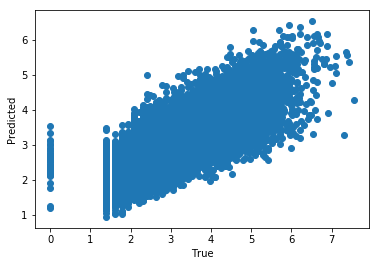

In [44]:
y_pred = mm.predict(X_train)

plt.scatter(y_train,y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

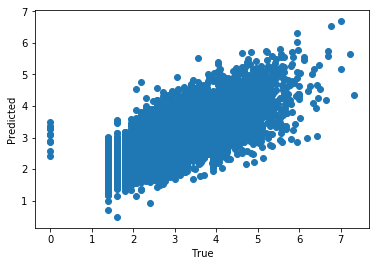

In [45]:
y_pred = mm.predict(X_valid)

plt.scatter(y_valid,y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [25]:
min(y_valid[y_valid>0])

1.3862943611198906

In [42]:
params2 = {
        'learning_rate': 1,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 120,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
}

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)


watchlist2 = [d_valid]    
model = lgb.train(params2, train_set=d_train, num_boost_round=8000, valid_sets=watchlist2, \
    early_stopping_rounds=250, verbose_eval=1000)     

y_pred = model.predict(X_valid)

y_pred[y_pred<0] = 0
print ("RMSLE: ",rmsle(y_valid,y_pred))
print ("RMSE: ",mean_squared_error(y_valid,y_pred))
print ("R2: ",r2_score(y_valid,y_pred))


Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[106]	valid_0's rmse: 0.588073
RMSLE:  0.147631713165
RMSE:  0.345829469307
R2:  0.406492131993


In [31]:
lgb.Dataset??

In [35]:
lgb.train??

In [43]:
lgb.train??